<a href="https://colab.research.google.com/github/ltirrell/network_workshop/blob/reformatting/R_Wildlife_Trade_Network_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# URI Illegal Wildlife Trafficking: R workshop in network analysis

## Setup

This section installs and loads all the packages we need, and downloads the CITES dataset using the [citesdb](https://github.com/ropensci/citesdb) package.  We'll call this dataset `master`.

This takes approximately 10-15 minutes to run.

In [1]:
install.packages("igraph")
devtools::install_github("ropensci/citesdb")

library(igraph)
library(tidyverse)
library(citesdb)

# Collect dataset, and remove NA's from the Importer/Exporter columns
cites_db_download()
master <- cites_shipments() %>% 
    collect()
master$Importer[is.na(master$Importer)] <- ""
master$Exporter[is.na(master$Exporter)] <- ""

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




MonetDBLite (NA     -> ef2eac03f...) [GitHub]
rappdirs    (NA     -> 0.3.1       ) [CRAN]
R.utils     (NA     -> 2.9.2       ) [CRAN]
curl        (4.2    -> 4.3         ) [CRAN]
jsonlite    (1.6    -> 1.6.1       ) [CRAN]
mime        (0.8    -> 0.9         ) [CRAN]
R.oo        (NA     -> 1.23.0      ) [CRAN]
R.methodsS3 (NA     -> 1.8.0       ) [CRAN]
cli         (2.0.1  -> 2.0.2       ) [CRAN]
vctrs       (0.2.2  -> 0.2.3       ) [CRAN]
digest      (0.6.23 -> 0.6.25      ) [CRAN]


digest (0.6.23 -> 0.6.25) [CRAN]


Installing 1 packages: digest

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpOFngMk/remotes772eb9719a/cran-MonetDBLite-ef2eac0/DESCRIPTION’
─  preparing ‘MonetDBLite’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘MonetDBLite_0.6.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing 10 packages: rappdirs, R.utils, curl, jsonlite, mime, R.oo, R.methodsS3, cli, vctrs, digest

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Skipping install of 'MonetDBLite' from a github remote, the SHA1 (ef2eac03) has not changed since last install.
  Use `force = TRUE` to force installation



✔  checking for file ‘/tmp/RtmpOFngMk/remotes77559a7bdf/ropensci-citesdb-4da9daa/DESCRIPTION’
─  preparing ‘citesdb’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘citesdb_0.2.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::groups()        masks igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()



## Test
Before we begin the class, let's make sure we can run some simple code and plot a graph. 
Click on each cell of code and press "shift + enter"

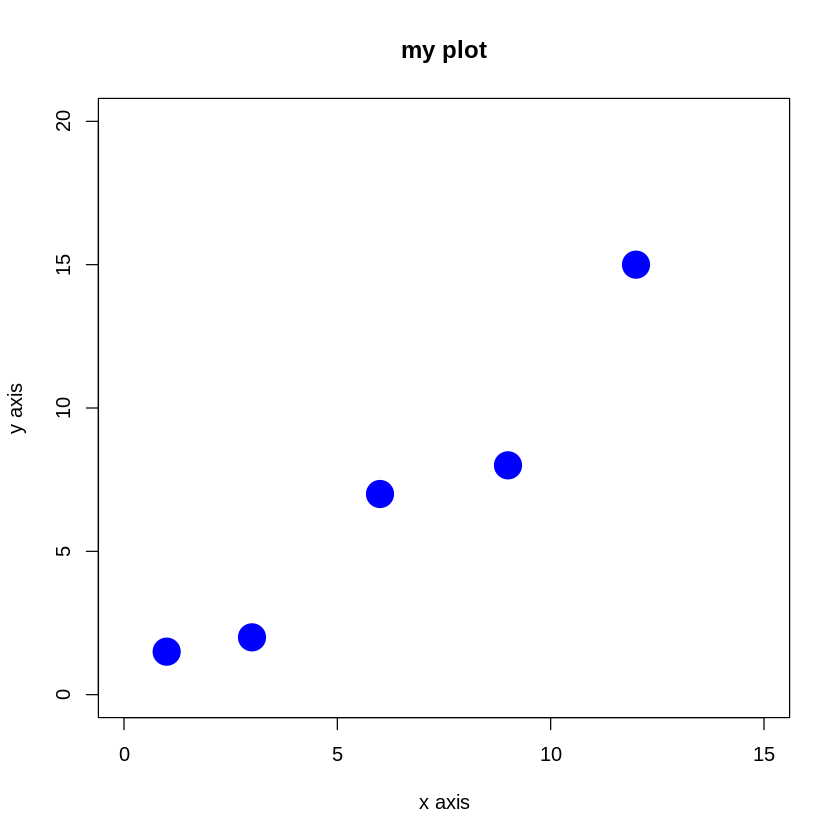

In [2]:
x <- c(1,3,6,9,12)
y <- c(1.5,2,7,8,15)
plot(
    x, y, 
    xlab="x axis", 
    ylab="y axis", 
    main="my plot",
    ylim=c(0,20),
    xlim=c(0,15), 
    pch=19,
    col="blue",
    cex=3
)

If you see a simple scatter plot with 5 data points, you have successfully run R code!

## Explore the CITES dataset

In [3]:
str(master)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	20215030 obs. of  19 variables:
 $ Year                  : int  1975 1975 1975 1975 1975 1975 1975 1975 1975 1975 ...
 $ Appendix              : chr  "II" "II" "I" "I" ...
 $ Taxon                 : chr  "Ailurus fulgens" "Aldabrachelys gigantea" "Alligator mississippiensis" "Anodorhynchus leari" ...
 $ Class                 : chr  "Mammalia" "Reptilia" "Reptilia" "Aves" ...
 $ Order                 : chr  "Carnivora" "Testudines" "Crocodylia" "Psittaciformes" ...
 $ Family                : chr  "Ailuridae" "Testudinidae" "Alligatoridae" "Psittacidae" ...
 $ Genus                 : chr  "Ailurus" "Aldabrachelys" "Alligator" "Anodorhynchus" ...
 $ Term                  : chr  "live" "bodies" "skins" "live" ...
 $ Quantity              : num  2 1 16 2 25 7 7 22 7 2 ...
 $ Unit                  : chr  NA NA NA NA ...
 $ Importer              : chr  "CH" "CH" "CH" "CH" ...
 $ Exporter              : chr  "DE" "SC" "DE" "PT" ...
 $ Origin           

In [4]:
head(master)

Year,Appendix,Taxon,Class,Order,Family,Genus,Term,Quantity,Unit,Importer,Exporter,Origin,Purpose,Source,Reporter.type,Import.permit.RandomID,Export.permit.RandomID,Origin.permit.RandomID
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1975,II,Ailurus fulgens,Mammalia,Carnivora,Ailuridae,Ailurus,live,2,NA,CH,DE,NA,Z,NA,I,NA,NA,NA
1975,II,Aldabrachelys gigantea,Reptilia,Testudines,Testudinidae,Aldabrachelys,bodies,1,NA,CH,SC,NA,NA,NA,I,NA,NA,NA
1975,I,Alligator mississippiensis,Reptilia,Crocodylia,Alligatoridae,Alligator,skins,16,NA,CH,DE,NA,NA,NA,I,NA,NA,NA
1975,I,Anodorhynchus leari,Aves,Psittaciformes,Psittacidae,Anodorhynchus,live,2,NA,CH,PT,NA,Z,NA,I,NA,NA,NA
1975,III,Balaenidae spp.,Mammalia,Cetacea,Balaenidae,NA,bone carvings,25,NA,BE,CA,NA,NA,NA,E,NA,NA,NA
1975,III,Balaenidae spp.,Mammalia,Cetacea,Balaenidae,NA,bone carvings,7,NA,CA,DE,CA,NA,NA,I,NA,NA,NA


In [5]:
min(master$Year) 

[1] 1975

In [6]:
max(master$Year) 

[1] 2018

In [7]:
table(master$Class) 


   Actinopteri       Amphibia       Anthozoa      Arachnida           Aves 
        314305          32595        3290126          11576         992282 
      Bivalvia    Cephalopoda    Coelacanthi      Dipneusti Elasmobranchii 
         94267             61             58            464           2225 
    Gastropoda   Hirudinoidea  Holothuroidea       Hydrozoa        Insecta 
         42226           8345            893          20579          52371 
      Mammalia       Reptilia 
       2243332        8161927 

In [8]:
sort(table(master$Class))


   Coelacanthi    Cephalopoda      Dipneusti  Holothuroidea Elasmobranchii 
            58             61            464            893           2225 
  Hirudinoidea      Arachnida       Hydrozoa       Amphibia     Gastropoda 
          8345          11576          20579          32595          42226 
       Insecta       Bivalvia    Actinopteri           Aves       Mammalia 
         52371          94267         314305         992282        2243332 
      Anthozoa       Reptilia 
       3290126        8161927 

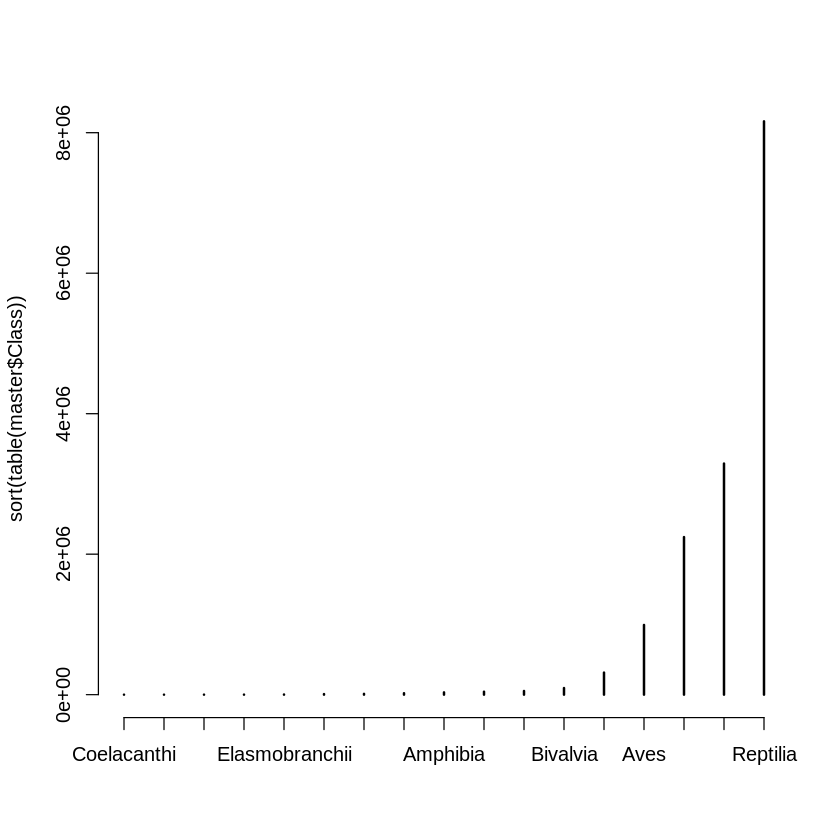

In [9]:
plot(sort(table(master$Class)))

## Functions

These functions will be used throughout this workshop to make things easier.

`create_network` makes an igraph network from a dataset, which we can use for further analysis and visualization.

`plot_network` allows us to plot an igraph network in a nicer way than by default, and easily change the edge weights

In [0]:
create_network <- function(data){
    # create a tibble of unique Exporter and Importer countries
    # this is used for the network nodes
    sources <- data %>%
        distinct(Exporter) %>%
        rename(label = Exporter)  # all exporting countries (treated as country of origin)
    destinations <- data %>%
        distinct(Importer) %>%
        rename(label = Importer)  # all importing countries
    nodes <- full_join(sources, destinations, by = "label")  # all unique countries in your dataset 
    nodes <- nodes %>%
        rowid_to_column("id")  # create numerical id for each unique country 

    # create a tibble with export id, import id, and weight by number of shipments
    # this is used for the network edges
    per_route <- data %>%  
        group_by(Exporter, Importer) %>%
        summarise(weight = n()) %>% #number of observations in the current group
        ungroup() #removes grouping 
    edges <- per_route %>% 
        left_join(nodes, by = c("Exporter" = "label")) %>% 
        rename(from = id)
    edges <- edges %>% 
        left_join(nodes, by = c("Importer" = "label")) %>% 
        rename(to = id)
    edges <- select(edges, from, to, weight)

    # create a directed igraph network from the edges and nodes defined above   
    net <- graph_from_data_frame(d=edges, vertices=nodes, directed=T)
    return(net)
}


plot_network <- function(
    igraph_network,
    title="trade network",
    weight_factor=0.01, # scaling factor for edge weights
    layout=layout_with_mds  # igraph layour
    ){
    E(igraph_network)$width <- E(igraph_network)$weight*weight_factor
    l <- layout(igraph_network)
    plot(
        # TODO: adjust plot size, etc to make look niceer in Colab
        igraph_network,
        edge.color= rgb(70/255, 130/255, 180/255, 0.6),
        edge.arrow.size=.001, 
        vertex.size = 10, 
        vertex.color="gold", #(65,105,225)
        vertex.label = V(igraph_network)$id,
        vertex.label.cex = 0.6, 
        vertex.label.color = "black", 
        rescale=T, 
        layout=l*3.0, 
        main=title) 
}

## Create and visualize network

Now we'll start to explore the network, where each node is a country. See Annex 3 of the [CITES Trade Database Guide](https://trade.cites.org/cites_trade_guidelines/en-CITES_Trade_Database_Guide.pdf) to look up the country name from its 2-letter code.

In [0]:
master_network <-create_network(master) 

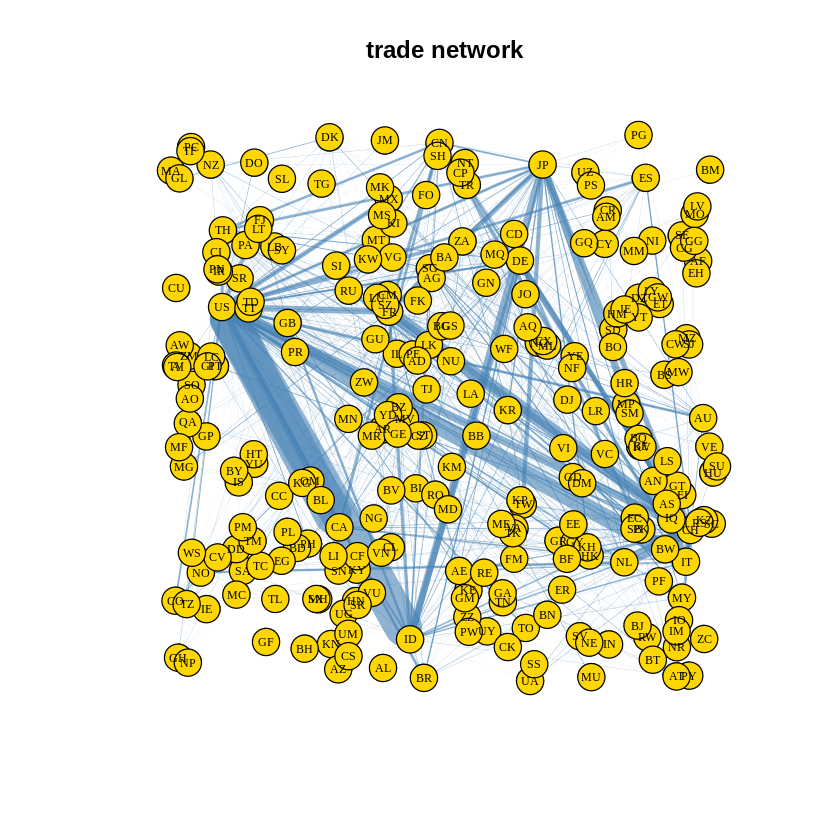

In [25]:
plot_network(master_network, weight_factor=0.00002, layout = layout_randomly)

We'll remove some nodes (such as Unknown or blank country names), to clean up our dataset.

In [0]:
# get vertex ID of ambiguous country codes
unknown <- which(V(master_network)$label == "XX")
various <- which(V(master_network)$label == "XV")
blank <- which(V(master_network)$label == "")
# delete them from our network
master_network <- delete_vertices(master_network, c(unknown, blank, various))

Next, we'll remove nodes with weights less than 2000, so we can see the major nodes in our network.

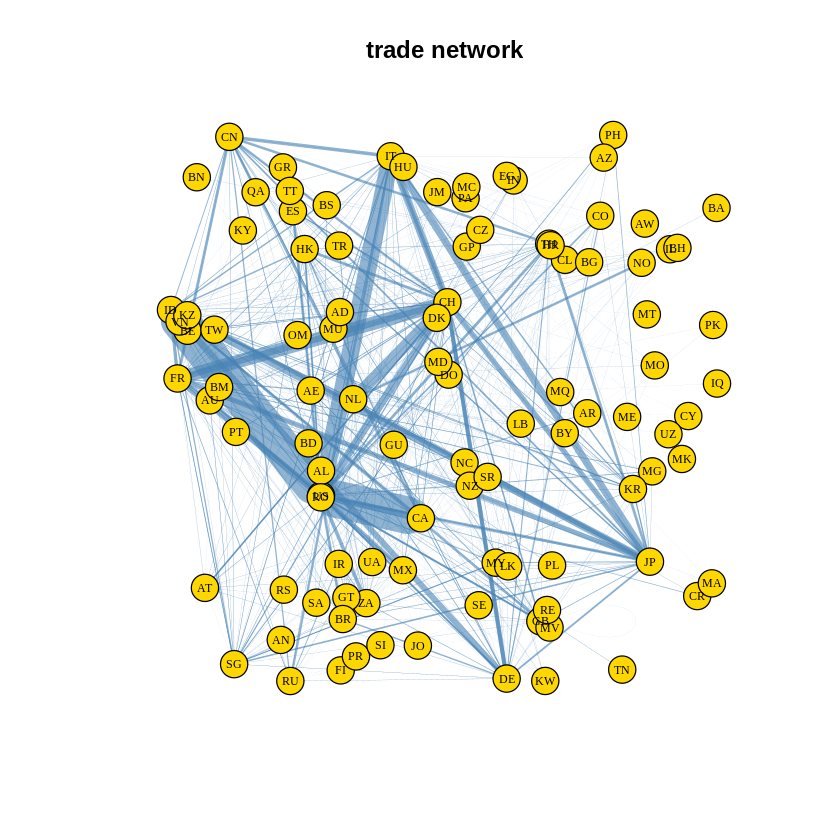

In [37]:
s1 <- subgraph.edges(master_network, E(master_network)[E(master_network)$weight>2000], del=F)
s2 <- delete_vertices(s1, degree(s1, mode = "in")==0)
plot_network(s2, weight_factor=0.00002, layout = layout_randomly)

There are many different network layouts in igraph. Let's try some of them:

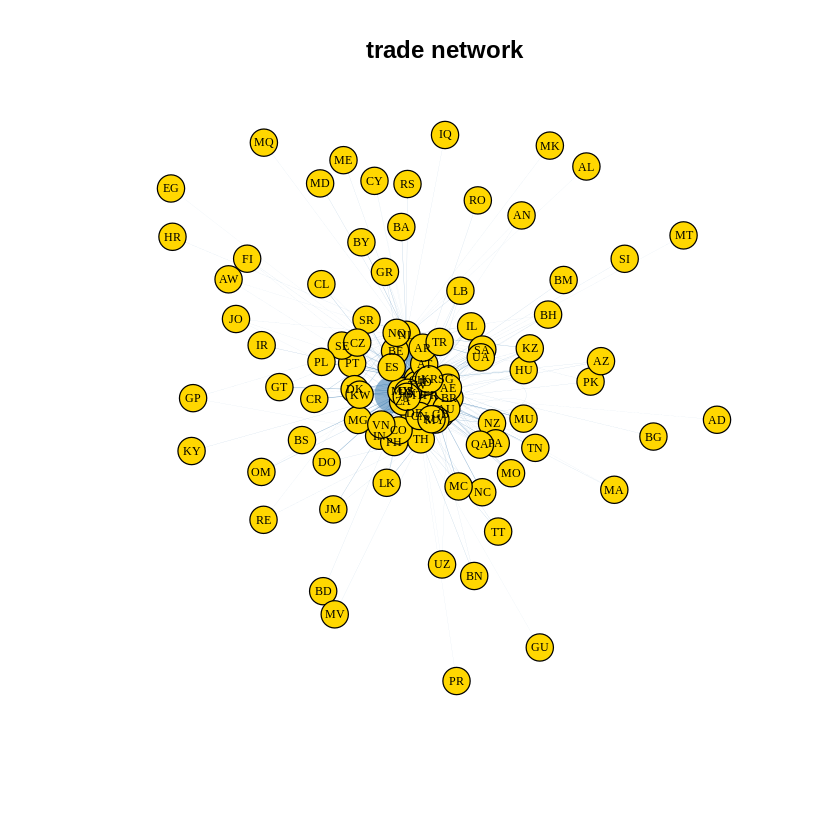

In [38]:
plot_network(s2, weight_factor=0.00002, layout = layout_with_fr)

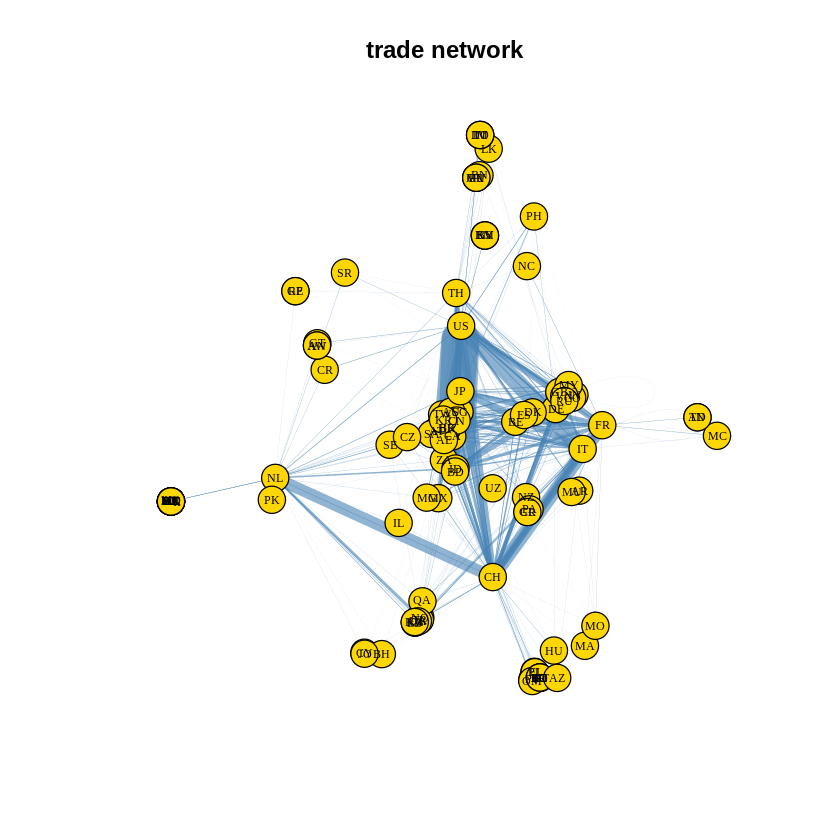

In [39]:
plot_network(s2, weight_factor=0.00002, layout = layout_with_mds)

## Create 2 subsets of the data, create networks, and visually compare them

In [0]:
Amp_1992 <- subset(master, Class == "Amphibia" & Year == "1992")  # Create subset of Amphibia data from 1992
Amp_2012 <- subset(master, Class == "Amphibia" & Year == "2012")  # Create subset of Amphibia data from 2012

In [0]:
# Create networks from these subsets
net1 <-create_network(Amp_1992)
net2 <-create_network(Amp_2012)

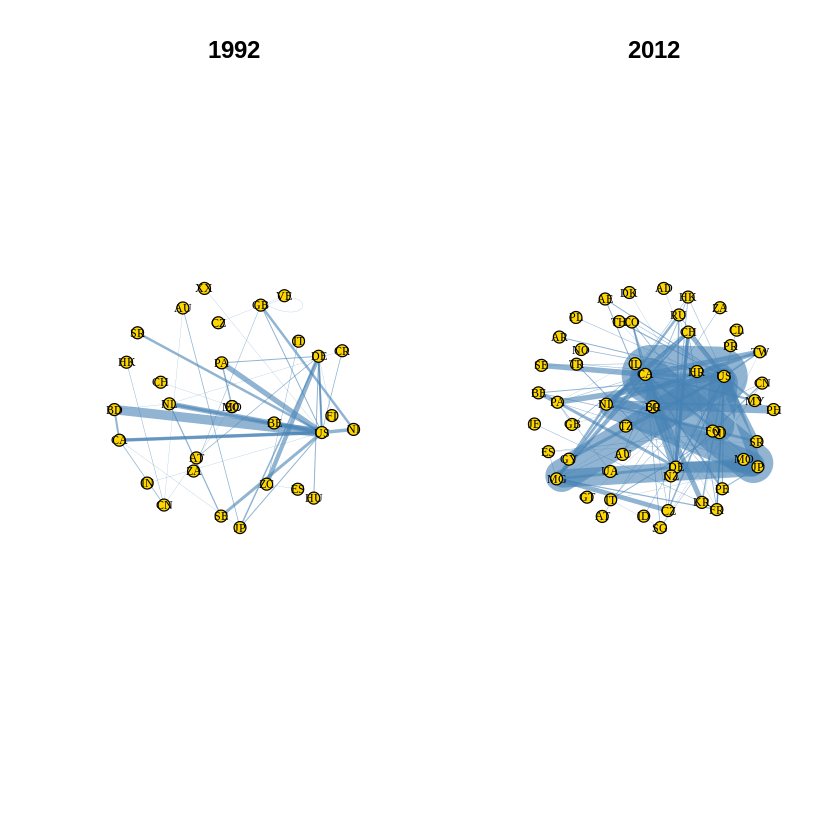

In [43]:
par(mfrow=c(1,2))  # create a graph with 1 row and 2 columns of plots
plot_network(net1, title="1992", weight_factor=0.2, layout= layout_on_sphere)
plot_network(net2, title="2012", weight_factor=0.2, layout= layout_on_sphere)

## Cluster analysis

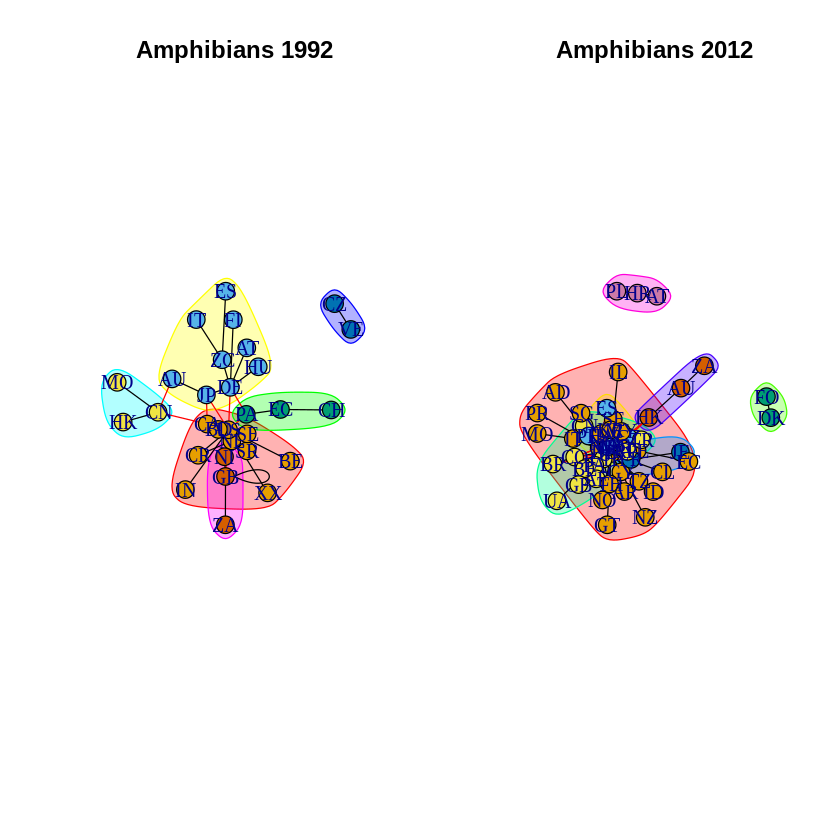

In [44]:
par(mfrow=c(1,2))  # create a graph with 1 row and 2 columns of plots
cfg <- cluster_fast_greedy(as.undirected(net1))  # run clustering algorthim on our first network
plot(cfg, as.undirected(net1)) 
title(main = "Amphibians 1992")
cfg <- cluster_fast_greedy(as.undirected(net2)) # run clustering algorthim on our first network
plot(cfg, as.undirected(net2)) 
title(main = "Amphibians 2012")

## Exercise


Modify the above 4 sections of code to compare two

## Network and node descriptive stats

In [0]:
ecount(net1)/(vcount(net1)*(vcount(net1)-1)) #for a directed network
ecount(net2)/(vcount(net2)*(vcount(net2)-1)) #for a directed network

In [0]:
reciprocity(net1)
reciprocity(net2)

In [0]:
transitivity(net1, type="global")
transitivity(net2, type="global")

In [0]:
diameter(net1, directed=F, weights=NA)
diameter(net2, directed=F, weights=NA)

In [0]:
deg1 <- degree(net1, mode="all") #NODE METRICS ************
plot(net1, vertex.size=deg1*3, edge.arrow.size=0.1)
hist(deg1, breaks=1:vcount(net1)-1, main="Histogram of node degree")

In [0]:
deg2 <- degree(net2, mode="all") #NODE METRICS ************
plot(net2, vertex.size=deg2*3, edge.arrow.size=0.1)
hist(deg2, breaks=1:vcount(net2)-1, main="Histogram of node degree")

## References
Ross, Noam, Evan A. Eskew, and Nicolas Ray. 2019. citesdb: A high-performance database of shipment-level CITES trade data. R package v0.2.0. EcoHealth Alliance: New York, NY. https://github.com/ropensci/citesdb. doi:10.5281/zenodo.2630836

UNEP-WCMC (Comps.) 2019. Full CITES Trade Database Download. Version 2019.2. CITES Secretariat, Geneva, Switzerland. Compiled by UNEP-WCMC, Cambridge, UK. Available at: https://trade.cites.org.